# NvTK workflow on the synthetic dataset

1. Initialized a baseline CNN model in NvTK, with filters numbers of 20, filter size of 30, and pooling size of 30 in the first convolutional layer for capturing the full motifs. 
2. Trained and evaluated the model performance with AUROC and AUPR metrics. 
3. Interpreted the sequence pattern deep learning represented internally for its accurate prediction. 
4. Applied NvTK gradient-based methods to query the filter contribution to different motif classifications.

In [1]:
import sys
sys.path.append("../NvTK/")
print(sys.path)

['/public/home/guogjgroup/ggj/JiaqiLi/NvTK/20220311-NvTK-WorkFlowOnSyntheticDataset', '/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python38.zip', '/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python3.8', '/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/public/home/guogjgroup/ggj/.ipython', '../NvTK/']


In [2]:
import h5py, os, argparse, logging, time

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from NvTK import Trainer
from NvTK.Model.ConvModel import CNN

from NvTK.Evaluator import calculate_roc, calculate_pr
from NvTK.Evaluator import show_auc_curve, show_pr_curve

from NvTK.Explainer import get_activate_W, meme_generate, save_activate_seqlets
from NvTK.Explainer import seq_logo, plot_seq_logo

In [3]:
os.makedirs("./Log", exist_ok=True)
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                    datefmt='%a, %d %b %Y %H:%M:%S',
                    filename=time.strftime('./Log/log_nvtk_minimal.%m%d.%H:%M:%S.txt'),
                    filemode='w')

# args
parser = argparse.ArgumentParser()
parser.add_argument("data")
parser.add_argument("--gpu-device", dest="device_id", default="0")
args = parser.parse_args(['../Dataset/synthetic_dataset_simple.h5', 
                          '--gpu-device', '1'])
logging.info(args)


In [4]:
## change device
os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Prepare dataset

1. unpack the h5file datasets
2. generate the DataLoader

In [5]:
# unpack datasets
h5file = h5py.File(args.data, 'r')
anno = h5file["annotation"][:]
x_train = h5file["train_data"][:].astype(np.float32)
y_train = h5file["train_label"][:].astype(np.float32)
x_val = h5file["val_data"][:].astype(np.float32)
y_val = h5file["val_label"][:].astype(np.float32)
x_test = h5file["test_data"][:].astype(np.float32)
y_test = h5file["test_label"][:].astype(np.float32)
h5file.close()

# unpack anno
n_tasks = anno.shape[0]
task_name = anno[:,0]

# define data loader
batch_size = 32
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,
                            shuffle=True, num_workers=2, drop_last=False, pin_memory=True)
validate_loader = DataLoader(list(zip(x_val, y_val)), batch_size=batch_size, 
                            shuffle=False, num_workers=2, drop_last=False, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size, 
                            shuffle=False, num_workers=2, drop_last=False, pin_memory=True)


## Define model

Initialized a baseline CNN model in NvTK, with filters numbers of 20, filter size of 30, and pooling size of 30 in the first convolutional layer for capturing the full motifs.

In [6]:
# define model
model = CNN(output_size=n_tasks, 
            out_planes=20, kernel_size=30, conv_args={}, 
            bn=False, pool_args={'kernel_size': 30}, 
            tasktype='classification')
model

CNN(
  (Embedding): BasicConvEmbed(
    (conv): Conv1d(4, 20, kernel_size=(30,), stride=(1,))
    (activation): ReLU()
    (pool): AvgPool1d(kernel_size=(30,), stride=(30,), padding=(0,))
  )
  (Encoder): Sequential(
    (Conv): BasicConv1d(
      (conv): Conv1d(20, 256, kernel_size=(3,), stride=(1,))
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
      (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
    (GAP): AdaptiveAvgPool1d(output_size=8)
    (Flatten): Flatten()
  )
  (Decoder): BasicLinearModule(
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Predictor): BasicPredictor(
    (Map): Linear(in_features=256, out_features=4, bias=True)
    (Pred): Softmax(di

In [7]:
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss().to(device)

trainer = Trainer(model, criterion, optimizer, device, 
                  tasktype='binary_classification', 
                  use_tensorbord=False, tensorbord_args={})

## Trained the model 

In [8]:
# train
trainer.train_until_converge(train_loader, validate_loader, test_loader, EPOCH=500)

In [ ]:
!tensorboard --logdir=runs --bind_all

## Evaluated the model¶

In [21]:
# model = torch.load("./Log/best_model.p")#trainer.load_best_model()
# model.load_state_dict(torch.load("./Log/best_model@0311_19:41:19.params.pth"))
# model.eval()
# trainer.model = model

In [22]:
# predict test-set
_, _, test_predictions, test_targets = trainer.predict(test_loader)

# metric test-set
fpr, tpr, roc_auc = calculate_roc(test_targets, test_predictions)
auroc = [roc_auc[k] for k in roc_auc.keys() if k not in ["macro", "micro"]] # dict keys ordered by default in py3.7+

p, r, average_precision = calculate_pr(test_targets, test_predictions)
aupr = [average_precision[k] for k in average_precision.keys() if k not in ["macro", "micro"]] # dict keys ordered by default in py3.7+

pd.DataFrame({"auroc":auroc, "aupr":aupr}, index=anno[:,0]).to_csv("Metric-simple.csv")
pd.DataFrame({"auroc":auroc, "aupr":aupr}, index=anno[:,0])

,auroc,aupr
CEBPB,0.993356,0.983342
CTCF,0.990042,0.973450
TP53,0.994228,0.986504
SRF,0.994355,0.986070


<Figure size 432x288 with 0 Axes>

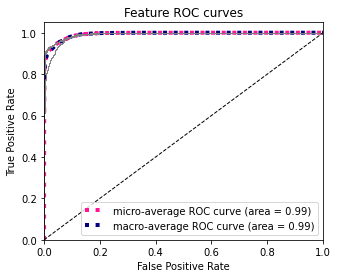

In [38]:
show_auc_curve(fpr=fpr, tpr=tpr, roc_auc=roc_auc, save=False, fig_size=(5, 4))

<Figure size 432x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

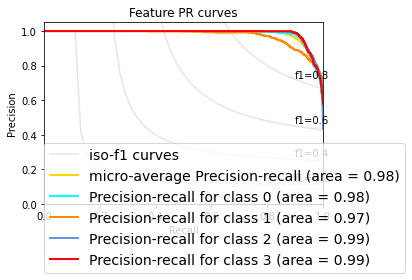

In [39]:
show_pr_curve(precision=p, recall=r, 
              average_precision=average_precision, 
              save=False, fig_size=(5, 4))

## Model Interpretation
The sequence pattern deep learning represented internally for its accurate prediction.

In [23]:
# explain
W = get_activate_W(model, model.Embedding.conv, test_loader, motif_width=30)
meme_generate(W, output_file='meme-simple.txt', prefix='Filter_')

save_activate_seqlets(model, model.Embedding.conv, test_loader, threshold=0.999,
                        out_fname='seqlets.fasta', motif_width=30)


CPU times: user 4.37 s, sys: 2.81 s, total: 7.18 s
Wall time: 20.2 s


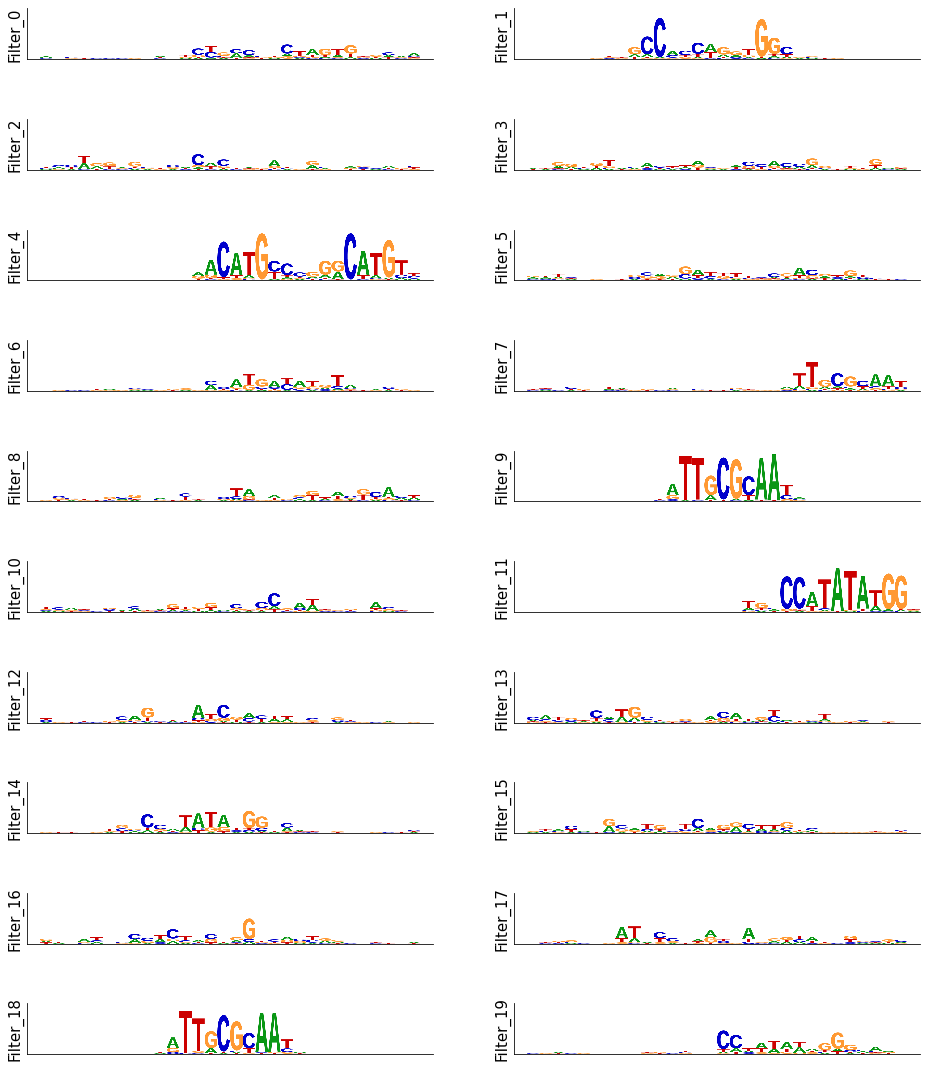

In [26]:
%%time

import matplotlib.pyplot as plt
from NvTK.Explainer import normalize_pwm

save_path = "./Motifs"

fig = plt.figure(figsize = (16, 20))
for j in range(len(W)):  
    
    plt.subplot(10, 2, j+1)
    logo = seq_logo(W[j], height=100, nt_width=50, norm=0, alphabet='dna')
    plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Filter_"+str(j), fontsize=15)

#     plt.subplot(8, 4, j*2+2)
#     logo = seq_logo(W[j][:,::-1][::-1,:], height=100, nt_width=50, norm=0, alphabet='dna')
#     plot_seq_logo(logo, nt_width=20, step_multiple=4)    
#     plt.xticks([])
#     plt.yticks([])

fig.savefig("Filters-simple-init.pdf", format='pdf', dpi=300, bbox_inches='tight')
fig.show()


## Gradient-based filter contribution
Applied NvTK gradient-based methods to query the filter contribution to different motif classifications.

In [28]:
%%time

imp = []
for tensor,_ in test_loader:
    tensor = tensor.to(device)
    conductance = deep_explain_layer_conductance(model, model.Embedding.conv, tensor, len(anno[:,0]))
    imp.append(conductance)

# plot_label_neuron_importance(model, model.Embedding.conv, tensor, anno[:,0])

/public/home/guogjgroup/ggj/anaconda3/envs/pytorch/lib/python3.8/site-packages/captum/attr/_utils/batching.py:55: UserWarning: This method computes finite differences between evaluations at consecutive steps, so internal batch size must be at least twice the number of examples. Defaulting to internal batch size of 64 equal to twice the number of examples.
  warnings.warn(


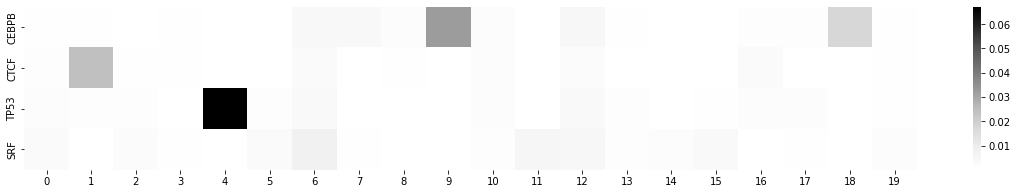

In [33]:
df = pd.DataFrame(np.hstack(imp).max(-1).mean(1), index=anno[:,0])
plt.figure(figsize=(20,3))
ax = sns.heatmap(df, cmap="Greys")
plt.savefig("label_neuron_importance.pdf")
plt.show()
plt.close()